# Using Uproot effectively

### If you're joining this tutorial live:

   1. Open this notebook in Binder or on your own computer (see [GitHub README](https://github.com/jpivarski-talks/2021-06-14-uproot-awkward-columnar-hats#readme)). If you have any troubles with installation or uninstalled libraries, switch to Binder.
   2. Open the Sli.do link that I'm sharing on the screen. This allows you to ask questions at any time, anonymously if you want.
   3. Evaluate the cells in the notebook along with me. I will frequently take detours, changing the input cells in real time. **Try out variations yourself, and ask questions at any time.**

Consider this a tour and I'm your tour guide. The notebook is a planned route to get things started, but your questions and wayfaring are more important.

### If you're reading this tutorial online or watching a video:

   * There's a directory of evaluated notebooks [in GitHub](https://github.com/jpivarski-talks/2021-06-14-uproot-awkward-columnar-hats), so you don't need to use Binder to see the cell output, but it's "canned," it doesn't include the experiments we tried on the day of the tutorial.
   * There are other tutorials on this subject. A very similar tutorial to this one will be presented at [PyHEP 2021](https://indico.cern.ch/event/1019958/) (July 5‒9, 2021). If that's in the future, join us! If that's in the past, the video is on YouTube.

## Python and Pythonic analysis tools (NumPy, Matplotlib, Pandas, etc.) are mainstream

This is an analysis of GitHub repos created by CMS physicists (i.e. "everyone who forked cms-sw/cmssw").

GitHub labels these repos as C/C++, Python, or Jupyter: the Python and Jupyter categories are now the most common.

<img src="img/lhlhc-github-languages.svg" style="width: 800px">

Furthermore, if we search for strings inside these repos, words like "`numpy`" are found in more repos than words like "`TFile`" (proxy for ROOT).

`"uproot"` is also fairly common, but not as much as the likes of NumPy and ROOT.

<img src="img/lhlhc-github-overlay-lin.svg" style="width: 800px">

We also asked questions about this at last year's PyHEP workshop (408 respondents, about 90 in CMS).

You use Python about equally with C++, and primarily for analysis (not just machine learning).

<img src="img/pyhep2020-survey-5.svg" style="width: 80%">

## Some general things about Python

   1. Python is fun and easy.
   2. Python is slow.

## What a ~complete analysis looks like in Python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

import uproot
import hist

In [2]:
upfile = uproot.open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")
uptree = upfile["Events"]

The general strategy is to get arrays in one function call (usually slow, has to read) and use them interactively afterward.

In [3]:
muons = uptree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"], cut="nMuon >= 2", how="zip", entry_stop=100000)

We've already applied an `nMuon >= 2` cut, but we can define additional cuts.

In [18]:
os_cut = muons[:, "Muon", "charge", 0] != muons[:, "Muon", "charge", 1]
os_cut

<Array [False, True, False, ... True, True] type='83343 * bool'>

Slicing (to be described in more detail later) can filter and reduce the structure of an array.

In [19]:
mu1 = muons[os_cut, 0, "Muon"]
mu2 = muons[os_cut, 1, "Muon"]
mu1

<Array [{pt: 10.5, eta: -0.428, ... charge: 1}] type='60216 * {"pt": float32, "e...'>

Make a histogram and fill it with a calculation from the array. The mini-plot is just the way this histogram type is visualized in Jupyter.

In [6]:
h1 = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()

In [7]:
h1.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 59917.0 (60216.0 with flow)

Plot it using Matplotlib (for logscale).

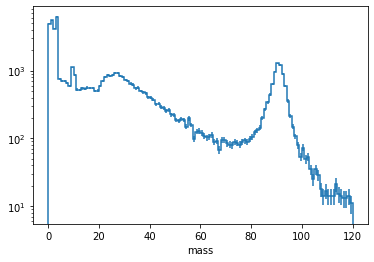

In [8]:
h1.plot()
plt.yscale("log")

## What a the same analysis looks like in PyROOT

In [9]:
import ROOT
c1 = ROOT.TCanvas()

Welcome to JupyROOT 6.24/00


In [10]:
rootfile = ROOT.TFile.Open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")
roottree = rootfile.Get("Events")

ROOT analyses (before RDataFrame; see below) are based on an event loop. Reading and calculations are done in the loop.

In [11]:
h2 = ROOT.TH1D("h2", "mass", 120, 0, 120)

for index, event in enumerate(roottree):
    # Analyzing a subsample means breaking out of the loop early.
    if index == 100000:
        break
    # Applying cuts means if-statements.
    if event.nMuon >= 2 and event.Muon_charge[0] != event.Muon_charge[1]:
        mu1_pt = event.Muon_pt[0]
        mu2_pt = event.Muon_pt[1]
        mu1_eta = event.Muon_eta[0]
        mu2_eta = event.Muon_eta[1]
        mu1_phi = event.Muon_phi[0]
        mu2_phi = event.Muon_phi[1]
        h2.Fill(np.sqrt(2*mu1_pt*mu2_pt*(np.cosh(mu1_eta - mu2_eta) - np.cos(mu1_phi - mu2_phi))))

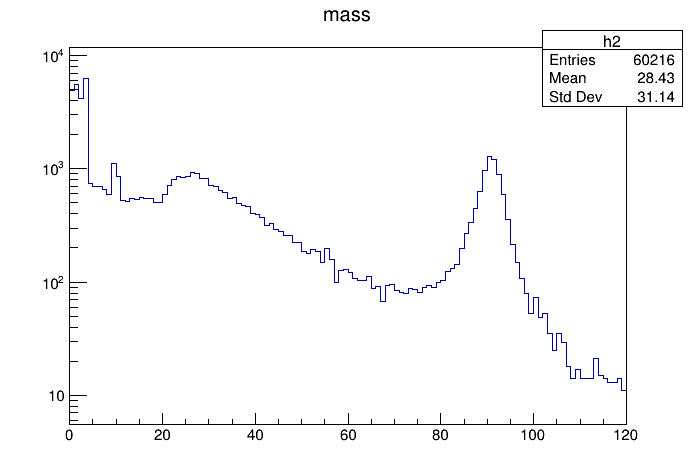

In [12]:
h2.Draw()
c1.SetLogy()
c1.Draw()

## What a the same analysis looks like in old C++

By "old C++," I mean `TTree::GetEntry`. This, also is a reading + calculating loop over events.

Use `ROOT.gInterpreter.Declare` to define a C++ function in Python that we can use through PyROOT.

In [13]:
ROOT.gInterpreter.Declare('''
void compute(TH1D& h3, TTree& roottree) {
    UInt_t nMuon;
    float Muon_pt[50];
    float Muon_eta[50];
    float Muon_phi[50];
    int32_t Muon_charge[50];

    roottree.SetBranchStatus("*", 0);
    roottree.SetBranchStatus("nMuon", 1);
    roottree.SetBranchStatus("Muon_pt", 1);
    roottree.SetBranchStatus("Muon_eta", 1);
    roottree.SetBranchStatus("Muon_phi", 1);
    roottree.SetBranchStatus("Muon_charge", 1);

    roottree.SetBranchAddress("nMuon", &nMuon);
    roottree.SetBranchAddress("Muon_pt", Muon_pt);
    roottree.SetBranchAddress("Muon_eta", Muon_eta);
    roottree.SetBranchAddress("Muon_phi", Muon_phi);
    roottree.SetBranchAddress("Muon_charge", Muon_charge);
    
    for (int index = 0; index < 100000; index++) {
        roottree.GetEntry(index);
        if (nMuon >= 2 && Muon_charge[0] != Muon_charge[1]) {
            float mu1_pt = Muon_pt[0];
            float mu2_pt = Muon_pt[1];
            float mu1_eta = Muon_eta[0];
            float mu2_eta = Muon_eta[1];
            float mu1_phi = Muon_phi[0];
            float mu2_phi = Muon_phi[1];
            h3.Fill(sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi))));
        }
    }
}
''')

True

In [14]:
rootfile = ROOT.TFile.Open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")
roottree = rootfile.Get("Events")

h3 = ROOT.TH1D("h3", "mass", 120, 0, 120)

ROOT.compute(h3, roottree)

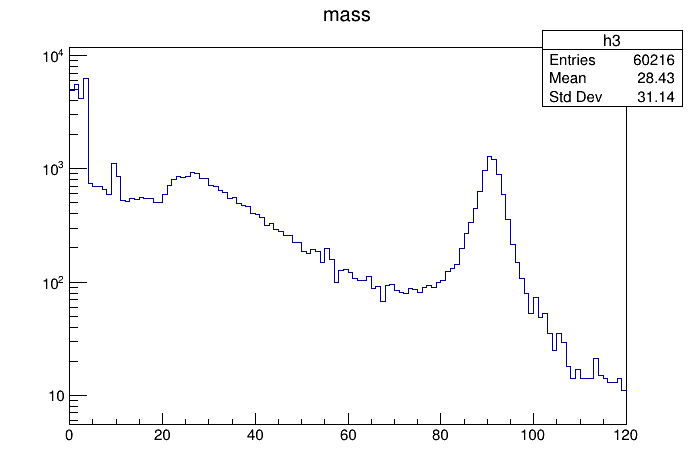

In [15]:
h3.Draw()
c1.SetLogy()
c1.Draw()

## What a the same analysis looks like in modern RDataFrame

This case mixes Python (for organization) with C++ (for speed).

<img src="img/rdataframe-flow.svg" style="width: 800px">

In [16]:
df = ROOT.RDataFrame("Events", "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")

# Each node is connected to the previous, in a chain (which can split and recombine).
df_limit = df.Range(100000)
df_2mu = df_limit.Filter("nMuon >= 2")
df_os = df_2mu.Filter("Muon_charge[0] != Muon_charge[1]")

# This node is a big C++ block.
df_mass = df_os.Define("Dimuon_mass", '''
float mu1_pt = Muon_pt[0];
float mu2_pt = Muon_pt[1];
float mu1_eta = Muon_eta[0];
float mu2_eta = Muon_eta[1];
float mu1_phi = Muon_phi[0];
float mu2_phi = Muon_phi[1];
return sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)));
''')

# This one is an endpoint (action).
h4 = df_mass.Histo1D(("h3", "mass", 120, 0, 120), "Dimuon_mass")

The above just sets up the calculation (compiling the C++ strings). It runs when you evaluate `h4.Draw`.

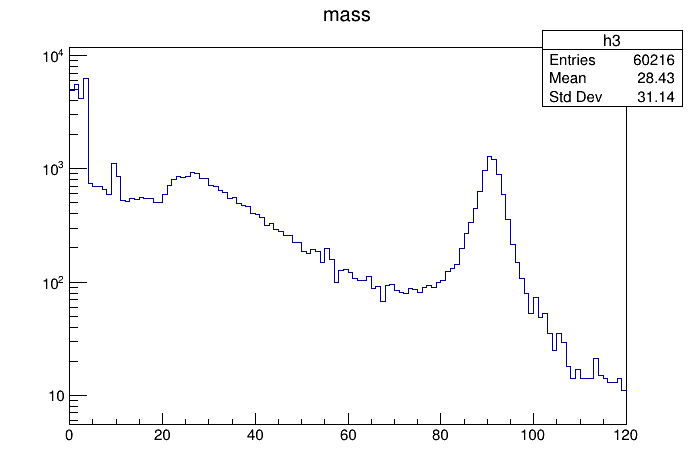

In [17]:
h4.Draw()   # <--- This is the line that computes everything.
c1.SetLogy()
c1.Draw()

For more on RDataFrame, see [this tutorial](https://cms-opendata-workshop.github.io/workshop-lesson-root/05-rdataframe/index.html).